# Radial Basis Function and Probabilistic Neural Networks

In this assignment, we will use the dataset for the tyreoid problem and the RBF and Probabilistic NNs.

Dataset available at:

- https://archive.ics.uci.edu/ml/datasets/Thyroid+Disease
- http://networkrepository.com/thyroid-disease-thyroid0387.php
- https://search.r-project.org/CRAN/refmans/MoTBFs/html/thyroid.html


## 1. Initial Considerations

Considering the problem of desease diagnostic, we focus on maximizing the rate of TP over all predictions made by the model.

In this way, we focus on trying to make the model predict correctly all the cases where the patients has a desease.
The classes are the following:

- 1 (normal)
- 2 (hyperthyroidism)
- 3 (hypothyroidism)

We want the best recall possible for classes 2 and 3.


## 2. Importing libraries


In [3]:
import os

import pandas as pd
import io
import requests
import numpy as np
import math+
import itertools    
import random

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

import tensorflow as tf

print("TF version:", tf.version)

import seaborn as sns
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import Adam, RMSprop, Adadelta, Adagrad, Adamax,Nadam


from tensorflow.python.client import device_lib
print("Is GPU backend?\n", device_lib.list_local_devices())

import matplotlib.pyplot as plt
from collections import Counter


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report,recall_score
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import warnings
warnings.filterwarnings("ignore")

TF version: <module 'tensorflow._api.v2.version' from '/home/trdp/anaconda3/envs/ml_env/lib/python3.7/site-packages/tensorflow/_api/v2/version/__init__.py'>
Is GPU backend?
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8818130222462096974
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1717698560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6104386500759312738
physical_device_desc: "device: 0, name: NVIDIA GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


2022-07-09 22:50:00.750154: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-09 22:50:00.750392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 22:50:00.750757: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce 940MX computeCapability: 5.0
coreClock: 1.189GHz coreCount: 3 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 37.33GiB/s
2022-07-09 22:50:00.750847: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-09 22:50:00.750887: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-07-09 22:50:00.750915: I tensorflow/stream_executor/platform/defa

## 3. Downloading Dataset

- The first step is the download of dataset and transform it into a pandas dataframe


In [4]:
print("Downloading the train dataset")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-train.data"
s = requests.get(url).contents=requests.get(url).content
print("Tranform to pandas dataframe")
dataTrain=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)


print("Shape:", dataTrain.shape)
print("Head")
dataTrain.head()

Tranform to pandas dataframe
Shape: (3772, 24)
Head


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0.00060,0.015,0.120,0.082,0.146,3,NaN,NaN
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0.00025,0.030,0.143,0.133,0.108,3,NaN,NaN
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0.00190,0.024,0.102,0.131,0.078,3,NaN,NaN
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0.00090,0.017,0.077,0.090,0.085,3,NaN,NaN
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0.00025,0.026,0.139,0.090,0.153,3,NaN,NaN


In [5]:
#
# Downloading test data
#
print("Downloading the test dataset")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-test.data"
s = requests.get(url).contents=requests.get(url).content

print("Tranform to pandas dataframe")
dataTest=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)

print("Shape:", dataTrain.shape)
print("Head")
dataTest.head()

Tranform to pandas dataframe
Shape: (3772, 24)
Head


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.29,0,0,0,0,0,0,0,0,0,...,0,0,0.0061,0.028,0.111,0.131,0.085,2,NaN,NaN
1,0.32,0,0,0,0,0,0,0,0,0,...,0,0,0.0013,0.019,0.084,0.078,0.107,3,NaN,NaN
2,0.35,0,0,0,0,0,0,0,0,0,...,0,0,0.0000,0.031,0.239,0.100,0.239,3,NaN,NaN
3,0.21,0,0,0,0,0,0,0,0,0,...,0,0,0.0010,0.018,0.087,0.088,0.099,3,NaN,NaN
4,0.22,0,0,0,0,1,0,0,0,0,...,0,0,0.0004,0.022,0.134,0.135,0.099,3,NaN,NaN


## 4. Data Preparation


- Let's define a function to separate the variables from labels and return the $X$ and $y$


In [6]:
def build_x_y(data):
    data_copy = data.copy()

    del data_copy[22]
    del data_copy[23]    
    X = data_copy.drop([21], axis=1)
    y = data_copy[21] - 1
    
    return X, y

- Applying to the two dataset (train and test)


In [7]:
X_train,y_train = build_x_y(dataTrain)
X_test,y_test = build_x_y(dataTest)

print("Label distribution:")
print("-> Train: ", Counter(y_train))
print("-> Test:  ", Counter(y_test))

print(y_train.shape)

Label distribution:
-> Train:  Counter({2: 3488, 1: 191, 0: 93})
-> Test:   Counter({2: 3178, 1: 177, 0: 73})
(3772,)


- Now, let's normalize the datasets using either `MinMaxScaler` or `StandardScaler`


In [8]:
from sklearn.preprocessing import  MinMaxScaler, StandardScaler, RobustScaler

NORM_METHODS = {
    "minmax":MinMaxScaler(feature_range=(0,1), clip=False),
    "std":StandardScaler(),
    "robust":RobustScaler()
}

def normalize(X_train, X_test, transform=True, method="robust"):
    scaler = NORM_METHODS[method]

    train_norm = X_train
    test_norm = X_test

    scaler.fit(X_train)
    if transform:
        train_norm =scaler.transform(X_train)
        test_norm = scaler.transform(X_test)

    return train_norm, test_norm


In [9]:
X_train_nm, X_test_nm = normalize(X_train, X_test)

In [10]:
#
# Calculating class weights
#
class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(y_train), y=y_train)
print("Labels:", np.unique(y_train))
print("Class weights:", class_weights)
d_class_weights = dict(enumerate(class_weights))

Labels: [0 1 2]
Class weights: [13.51971326  6.58289703  0.36047401]


In [11]:
Y_train =  tf.keras.utils.to_categorical(y_train, num_classes=3)
Y_test =  tf.keras.utils.to_categorical(y_test, num_classes=3)

In [12]:
X_train_nm, X_val_nm, Y_train, Y_val = train_test_split(X_train_nm, Y_train, test_size=0.2, stratify=Y_train, random_state=123)

## 5. Radial Basis Function (RBF) networks


- In this section, we will use RBF network in the classification task for the tyreoid dataset.
- We use a library called `rbf_keras` which implements a Layer class for Keras models [1].


In [13]:
tf.keras.backend.clear_session()
from rbf_layer.rbflayer import RBFLayer
from rbf_layer.rbflayer import InitCentersRandom
from rbf_layer.kmeans_initializer import InitCentersKMeans

- Training the model


In [14]:
tf.keras.backend.clear_session()
num_inputs = X_train_nm.shape[1]

model = Sequential()
rbflayer = RBFLayer(100,
                    initializer=InitCentersKMeans(X_train_nm),
                    betas=2.0,
                    input_shape=(num_inputs,))

model.add(rbflayer)
model.add(Dense(3, activation="softmax"))
metrics = [
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Accuracy(name="accuracy")
    ]

model.compile(loss='categorical_crossentropy',
                optimizer=Adam(1e-3), metrics=metrics)

print("Fitting")
history = model.fit(X_train_nm, Y_train,
                    batch_size=32,
                    epochs=200,
                    verbose=1,
                    validation_data=(X_val_nm, Y_val),
                    class_weight=d_class_weights
                    )

y_pred = np.argmax(model.predict(X_test_nm), axis=1)


2022-07-09 22:50:16.746517: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-09 22:50:16.746771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 22:50:16.747169: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce 940MX computeCapability: 5.0
coreClock: 1.189GHz coreCount: 3 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 37.33GiB/s
2022-07-09 22:50:16.747273: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-09 22:50:16.747315: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-07-09 22:50:16.747341: I tensorflow/stream_executor/platform/defa

Fitting
Epoch 1/200


2022-07-09 22:50:18.071990: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-09 22:50:18.095355: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz
2022-07-09 22:50:19.160924: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


95/95 [==============================] - 2s 10ms/step - loss: 1.1337 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 1.0595 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/200
95/95 [==============================] - 0s 4ms/step - loss: 1.1321 - precision: 0.4896 - recall: 0.0032 - accuracy: 0.0000e+00 - val_loss: 1.0026 - val_precision: 1.0000 - val_recall: 0.0543 - val_accuracy: 0.0000e+00
Epoch 3/200
95/95 [==============================] - 0s 4ms/step - loss: 0.9480 - precision: 0.9896 - recall: 0.0772 - accuracy: 0.0000e+00 - val_loss: 0.9186 - val_precision: 1.0000 - val_recall: 0.1748 - val_accuracy: 0.0000e+00
Epoch 4/200
95/95 [==============================] - 1s 7ms/step - loss: 1.0100 - precision: 1.0000 - recall: 0.1924 - accuracy: 0.0000e+00 - val_loss: 0.8279 - val_precision: 1.0000 - val_recall: 0.2834 - val_accuracy: 0.0000e+00
Epoch 5/200
95/95 [==============================] - 1s 6ms/step - loss

In [15]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.96      0.70        73
           1       0.65      0.98      0.78       177
           2       1.00      0.96      0.98      3178

    accuracy                           0.96      3428
   macro avg       0.74      0.96      0.82      3428
weighted avg       0.97      0.96      0.96      3428



[[  70    3    0]
 [   4  173    0]
 [  52   90 3036]]


<AxesSubplot:>

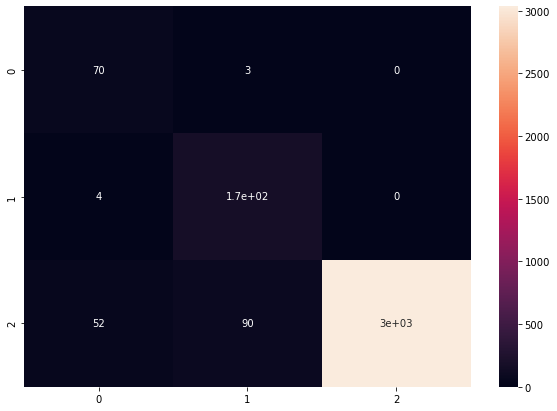

In [16]:
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
print(cm)
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)


In [17]:
sample_index = random.sample(range(0, len(y_test)), 5)
print(list(y_test[sample_index]))
print(list(y_pred[sample_index]))
#centers = rbflayer.get_we

print(Counter(y_pred))
print(Counter(y_test))

[2, 2, 1, 2, 2]
[2, 2, 1, 2, 2]
Counter({2: 3036, 1: 266, 0: 126})
Counter({2: 3178, 1: 177, 0: 73})


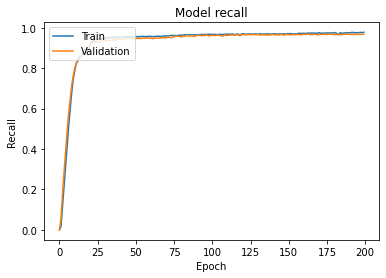

In [18]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

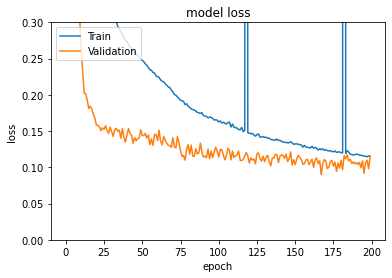

In [19]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0,0.3])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 6. Probabilistic Neural Networks

- In this section, we will use Probabilistic Neural Networks to the classification task for the tyreoid dataset.
- 


## 6.1 Downloading Dataset


- The first step is the download of dataset and transform it into a pandas dataframe



In [20]:
print("Downloading the train dataset")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-train.data"
s = requests.get(url).contents=requests.get(url).content
print("Tranform to pandas dataframe")
dataTrain=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)


print("Shape:", dataTrain.shape)
print("Head")
dataTrain.head()

Tranform to pandas dataframe
Shape: (3772, 24)
Head


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0.00060,0.015,0.120,0.082,0.146,3,NaN,NaN
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0.00025,0.030,0.143,0.133,0.108,3,NaN,NaN
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0.00190,0.024,0.102,0.131,0.078,3,NaN,NaN
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0.00090,0.017,0.077,0.090,0.085,3,NaN,NaN
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0.00025,0.026,0.139,0.090,0.153,3,NaN,NaN


In [21]:
#
# Downloading test data
#
print("Downloading the test dataset")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-test.data"
s = requests.get(url).contents=requests.get(url).content

print("Tranform to pandas dataframe")
dataTest=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)

print("Shape:", dataTrain.shape)
print("Head")
dataTest.head()

Tranform to pandas dataframe
Shape: (3772, 24)
Head


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.29,0,0,0,0,0,0,0,0,0,...,0,0,0.0061,0.028,0.111,0.131,0.085,2,NaN,NaN
1,0.32,0,0,0,0,0,0,0,0,0,...,0,0,0.0013,0.019,0.084,0.078,0.107,3,NaN,NaN
2,0.35,0,0,0,0,0,0,0,0,0,...,0,0,0.0000,0.031,0.239,0.100,0.239,3,NaN,NaN
3,0.21,0,0,0,0,0,0,0,0,0,...,0,0,0.0010,0.018,0.087,0.088,0.099,3,NaN,NaN
4,0.22,0,0,0,0,1,0,0,0,0,...,0,0,0.0004,0.022,0.134,0.135,0.099,3,NaN,NaN


In [22]:
X_train,y_train = build_x_y(dataTrain)
X_test,y_test = build_x_y(dataTest)

print("Label distribution:")
print("-> Train: ", Counter(y_train))
print("-> Test:  ", Counter(y_test))

print(y_train.shape)

Label distribution:
-> Train:  Counter({2: 3488, 1: 191, 0: 93})
-> Test:   Counter({2: 3178, 1: 177, 0: 73})
(3772,)


In [23]:
# Feature selection
fs = SelectKBest(score_func=chi2, k=10)

# learn relationship from training data
fs.fit(X_train, y_train)

# transform train input data
X_train_fs = fs.transform(X_train)

# transform test input data
X_test_fs = fs.transform(X_test)

In [24]:
X_train_nm, X_test_nm = normalize(X_train_fs, X_test_fs)

In [25]:
#
# Calculating class weights
#
class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(y_train), y=y_train)
print("Labels:", np.unique(y_train))
print("Class weights:", class_weights)
d_class_weights = dict(enumerate(class_weights))

Labels: [0 1 2]
Class weights: [13.51971326  6.58289703  0.36047401]


## 6.2 Implementing PNN

In this section, we implement a Probabilistic Neural Network for the tyreoid problem, based on the code from  JaeDukSeo github [2]

To simplify the problem, we will adjust our dataset to fit the structure used in the code we used.

In [26]:
number_of_features = X_train_nm.shape[1]
number_of_classes = len(np.unique(y_train))

In [27]:
feature_names = [ "Feature %d" %(i+1) for i in range(number_of_features)]

df_X_train_nm= pd.DataFrame(X_train_nm, columns=feature_names)
df_y_train= pd.DataFrame(list(y_train), columns=["Class"])

In [28]:
my_data = pd.concat([df_y_train, df_X_train_nm], axis=1)
my_data.head()

,Class,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10
0,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.555556,0.426471,1.310345
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.750000,1.102941,0.000000
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,-0.102941,-1.034483
3,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.388889,-0.838235,-0.793103
4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.750000,0.985294,1.551724


- Mostrando a correlação entre as variáveis e os labels

<AxesSubplot:>

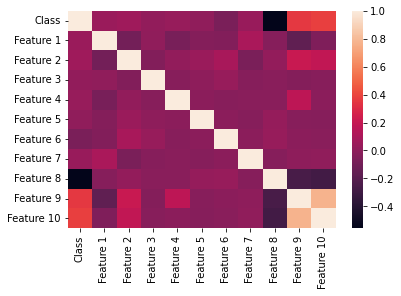

In [29]:

corr = my_data.corr()
sns.heatmap(my_data.corr(), 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [30]:
cleaned_data = np.array(my_data.drop(columns=["Class"]))

In [31]:
# 2. Declare the needed variable 
# Split the data by labels
groups = my_data.groupby('Class')


In [32]:
import tqdm

dictionary_of_sum = {}
sigma = 1
increament_current_row_in_matrix = 0

array_of_points = list(X_test_nm)
y_pred = []

print("Making predictions")
for x in tqdm.tqdm(array_of_points):
    point_want_to_classify = x

    # **INPUT LAYER OF THE PNN **
    # 4. Loop via number of classes 
    increament_current_row_in_matrix = 0
    for k in range(0,number_of_classes):

        # 4.1 Initiate the sume to zero 
        dictionary_of_sum[k] = 0
        number_of_data_point_from_class_k = len(groups.get_group(k))

        # ** PATTERN LAYER OF PNN **
        # 5. Loop via the number of training example in class i 
        product = 0.0

        for i in range(0,number_of_data_point_from_class_k):
            local_sum = 0
            for j_feature in range(number_of_features):
                value = (point_want_to_classify[j_feature] - cleaned_data[increament_current_row_in_matrix][j_feature]) * (point_want_to_classify[j_feature] - cleaned_data[increament_current_row_in_matrix][j_feature]) 
                local_sum += value

            temp_sum = -1 * local_sum
            temp_sum = temp_sum/( 2 * np.power(sigma,2) )

            product = product + temp_sum
            increament_current_row_in_matrix  = increament_current_row_in_matrix + 1

        dictionary_of_sum[k]  = product 

    # 
    #print(dictionary_of_sum)
    classified_class =  int(max(dictionary_of_sum, key=dictionary_of_sum.get) )
    y_pred.append(classified_class)

print(Counter(y_pred))



Making predictions


100%|██████████| 3428/3428 [04:19<00:00, 13.23it/s]

Counter({0: 3428})


In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.02      1.00      0.04        73
           1       0.00      0.00      0.00       177
           2       0.00      0.00      0.00      3178

    accuracy                           0.02      3428
   macro avg       0.01      0.33      0.01      3428
weighted avg       0.00      0.02      0.00      3428



[[  73    0    0]
 [ 177    0    0]
 [3178    0    0]]


<AxesSubplot:>

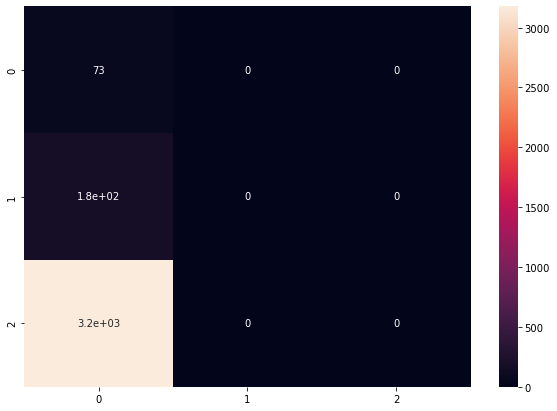

In [34]:
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
print(cm)
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

## References

[1] Vidnerová, Petra. **RBF-Keras: an RBF Layer for Keras Library**. 2019. Available at https://github.com/PetraVidnerova/rbf_keras

[2] JaeDukSeo. **Probabilistic neural network in python**. 2019. Available at https://github.com/JaeDukSeo/probabilistic-neural-network-in-python
